基于LSTM的情感分类

In [28]:
#环境配置
# -*- coding: utf-8 -*-
import numpy as np
import pickle as pkl
from tqdm import tqdm
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

In [29]:
# 超参数设置
data_path =  './data/data.txt'              # 数据集，包含积极和消极两种情绪
vocab_path = './data/vocab.pkl'             # Vocab公开词表
save_path = './lstm.ckpt'                   # 模型训练结果保存
embedding_pretrained = torch.tensor(np.load('./data/embedding_Tencent.npz')["embeddings"].astype('float32'))# 预训练词向量加载
embed = embedding_pretrained.size(1)        # 词向量维度
dropout = 0.5                               # 随机丢弃
num_classes = 2                             # 类别数
num_epochs = 50                             # epoch数
batch_size = 128                            # batch大小
pad_size = 50                               # 每句话处理成的长度
learning_rate = 1e-3                        # 学习率
hidden_size = 128                           # lstm隐藏层
num_layers = 2                              # lstm层数
MAX_VOCAB_SIZE = 10000                      # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'                 # 未知字，padding符号

In [30]:
#数据预处理
def load_dataset(path, pad_size, tokenizer, vocab):
    contents = []#新建列表，存储所有样本
    n=0
    with open(path, 'r', encoding='gbk') as f:#逐行读取文件内容
        for line in tqdm(f):
            lin = line.strip()#去除字符串line开头和结尾的空白字符，包括空格、制表符、换行符等，
            if not lin:#如果lin为空
                continue
            label,content = lin.split('	####	')#使用制表符作为标签和内容的分隔符
            words_line = []# word_line存储每个字的id
            token = tokenizer(content)# 分割器，分词每个字
            # print(token)
            seq_len = len(token)# 字的长度
            if pad_size:
                # 如果字长度小于指定长度，则填充，否则截断
                if seq_len < pad_size:
                    token.extend([vocab.get(PAD)] * (pad_size - len(token)))#填充
                else:
                    token = token[:pad_size]#截断
                    seq_len = pad_size
            # 将每个字映射为ID，如果在词表vocab中有word这个单词，那么就取出它的id；
            # 如果没有，就去除UNK（未知词）对应的id，其中UNK表示所有的未知词（out of vocab）都对应该id
            for word in token:
                words_line.append(vocab.get(word, vocab.get(UNK)))
            n+=1
            contents.append((words_line, int(label)))#将内容和标签添加到列表中，转换标签为整数型
    ## 将内容列表按照指定比例进行划分为训练集、开发集和测试集
    train, X_t = train_test_split(contents, test_size=0.2, random_state=42)# 划分训练集和剩余集合，比例为0.2
    dev,test= train_test_split(X_t, test_size=0.5, random_state=42) # 将剩余集合划分为验证集和测试集，比例为0.5
    return train,dev,test

def get_data():
    tokenizer = lambda x: [y for y in x]  # 定义分词器，此处为以字为单位的分词
    vocab = pkl.load(open(vocab_path, 'rb'))# 从磁盘加载词汇表
    # print('tokenizer',tokenizer)
    print('vocab',vocab)
    print(f"Vocab size: {len(vocab)}")# 打印词汇表大小

    train,dev,test = load_dataset(data_path, pad_size, tokenizer, vocab)# 调用load_dataset函数加载数据集
    return vocab, train, dev, test

In [31]:
#定义数据集类，用于处理文本数据。
class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')#是否有可用的GPU
        # 将数据转换为PyTorch张量，并将其移动到适当的设备（GPU或CPU）
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)#输入数据，通常表示文本数据，
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)# 标签数据，用于情绪分类
    def __getitem__(self,index):
        # 获取给定索引处的文本数据和标签数据
        self.text = self.x[index]# 获取第index个样本的文本数据
        self.label = self.y[index]# 获取第index个样本的标签数据
        return self.text, self.label# 返回文本数据和标签数据的元组
    def __len__(self):
        return len(self.x)# 返回文本数据的总样本数

In [32]:
# 定义LSTM模型
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #创建一个Embedding层，并使用预训练的嵌入进行初始化，同时设置不冻结参数（即可更新参数）
        self.embedding = nn.Embedding.from_pretrained(embedding_pretrained, freeze=False)
        # 创建一个LSTM层，输入维度为embed（嵌入维度），输出维度为hidden_size（隐藏层维度），层数为num_layers
        # 设置为双向LSTM，batch_first表示输入的第一个维度是批量大小，dropout表示应用丢弃的概率
        self.lstm = nn.LSTM(embed, hidden_size, num_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
         # 创建一个全连接层，输入维度为隐藏层大小的两倍（由于是双向LSTM），输出维度为num_classes（类别数）
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.fc_dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        # 前向传播过程
        # 将输入序列x进行词嵌入
        out = self.embedding(x)
        # 将嵌入后的序列输入LSTM层，获取输出序列
        # lstm 的input为[batchsize, max_length, embedding_size]，输出表示为 output,(h_n,c_n),
        out, _ = self.lstm(out)
        # 保存了每个时间步的输出，如果想要获取最后一个时间步的输出，则可以这么获取：output_last = output[:,-1,:]
        # 取LSTM输出序列中的最后一个时间步的结果作为模型的输出
        out = self.fc(out[:, -1, :]) 
        out = self.fc_dropout(out)
        return out

In [33]:
# 权重初始化，默认xavier
def init_network(model, method='xavier', exclude='embedding'):
     # 遍历模型中的所有参数
    for name, w in model.named_parameters():
        # 如果参数名不包含exclude指定的字符串
        if exclude not in name:
            # 如果参数名中包含'weight'，表示这是权重参数
            if 'weight' in name:
                # 根据初始化方法初始化权重参数
                if method == 'xavier':
                    # 使用Xavier正态分布初始化权重参数
                    nn.init.xavier_normal_(w)
                elif method == 'kaiming':
                    # 使用Kaiming正态分布初始化权重参数（适用于ReLU激活函数）
                    nn.init.kaiming_normal_(w)
                else:
                    # 使用标准正态分布初始化权重参数
                    nn.init.normal_(w)
            # 如果参数名中包含'bias'，表示这是偏置参数
            elif 'bias' in name:
                nn.init.constant_(w, 0)# 将偏置参数初始化为常数0
            else:
                pass

In [34]:
#损失绘制
def plot_loss(train_loss):
    plt.figure(figsize=(10, 7))# 创建一个绘图对象，并设置图像大小
    x = list(range(len(train_loss)))# 生成x轴数据，即训练损失的索引（代表每个epoch）
    plt.plot(x, train_loss, alpha=0.9, linewidth=2, label='train acc')# 绘制训练损失曲线，alpha表示透明度，linewidth表示线条宽度，label表示图例名称
    plt.xlabel('Epoch')# 设置x轴标签
    plt.ylabel('loss')# 设置y轴标签
    plt.legend(loc='best')# 添加图例，并设置其位置为最佳位置
    plt.savefig('./loss.png', dpi=400)# 将绘制好的图保存为图片文件，设置dpi为400，表示图像分辨率
#准确率绘制   
def plot_acc(train_acc):
    plt.figure(figsize=(10, 7))
    x = list(range(len(train_acc)))# 生成x轴数据，即训练准确率的索引（代表每个epoch）
    plt.plot(x, train_acc, alpha=0.9, linewidth=2, label='train acc')# 绘制训练准确率曲线，alpha表示透明度，linewidth表示线条宽度，label表示图例名称
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='best')
    plt.savefig('./acc.png', dpi=400)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
#定义模型训练
def train( model, dataloaders):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#优化器设置，使用Adam优化器进行参数更新
    loss_function = torch.nn.CrossEntropyLoss()#使用交叉熵损失函数计算损失

    dev_best_loss = float('inf') # 初始化最佳的验证集损失为正无穷大

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')#设备选择
    print("Start Training...\n")
    #初始化训练过程中的准确率和损失列表
    plot_train_acc = []
    plot_train_loss = []
    # 遍历每个epoch
    for i in range(num_epochs):
        step = 0 # 初始化步数
        train_lossi=0# 初始化训练损失
        train_acci = 0# 初始化训练准确率
        for inputs, labels in dataloaders['train']:# 遍历训练数据集
            model.train()# 设置模型为训练模式，可以更新参数
            # 将输入数据和标签移动到设备上
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()# 梯度清零，防止累加
            outputs = model(inputs) # 前向传播，计算模型输出
            loss = loss_function(outputs, labels)# 计算损失
            loss.backward()# 反向传播，计算梯度并更新参数
            optimizer.step()

            step += 1 # 步数加1
            true = labels.data.cpu()#真实标签
            predic = torch.max(outputs.data, 1)[1].cpu()#预测标签
            # 累加训练损失和训练准确率
            train_lossi += loss.item()
            train_acci += metrics.accuracy_score(true, predic)
        #对验证集进行评估    
        dev_acc, dev_loss = dev_eval(model, dataloaders['dev'], loss_function,Result_test=False)
        # 如果当前epoch的开发集损失比最佳损失小，则更新最佳损失并保存模型参数
        if dev_loss < dev_best_loss:
            dev_best_loss = dev_loss
            torch.save(model.state_dict(), save_path)
         # 计算当前epoch的平均训练准确率和训练损失
        train_acc = train_acci/step
        train_loss = train_lossi/step
         # 将训练准确率和训练损失添加到列表中
        plot_train_acc.append(train_acc)
        plot_train_loss.append(train_loss)
        # 打印当前epoch的训练和开发集指标
        print("epoch = {} :  train_loss = {:.3f}, train_acc = {:.2%}, dev_loss = {:.3f}, dev_acc = {:.2%}".
                  format(i+1, train_loss, train_acc, dev_loss, dev_acc))
    # 绘制训练过程中的损失曲线和准确率曲线
    plot_loss(plot_train_loss)
    plot_acc(plot_train_acc)
    # 加载最佳模型参数并在测试集上进行评估
    model.load_state_dict(torch.load(save_path))#模型加载
    model.eval()#设置验证模型
    test_acc, test_loss = dev_eval(model, dataloaders['test'], loss_function,Result_test=True)#输出准确率和损失
    print('================'*8)
    print('test_loss: {:.3f}      test_acc: {:.2%}'.format(test_loss, test_acc))
# 对测试结果进行分析
def result_test(real, pred):
    acc = accuracy_score(real, pred)  # 准确率计算
    print("Accuracy: {:.2%}".format(acc))

    # 混淆矩阵
    conf_matrix = confusion_matrix(real, pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC曲线和AUC
    fpr, tpr, _ = roc_curve(real, pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 你可以在这里添加更多的评估指标，如精确率、召回率、F1-score等

# 模型评估函数定义
def dev_eval(model, data, loss_function,Result_test=False):

    model.eval()#设置模型为评估模式
    loss_total = 0 # 初始化总损失
    predict_all = np.array([], dtype=int)# 初始化所有预测标签
    labels_all = np.array([], dtype=int)# 初始化所有真实标签
    with torch.no_grad():
        # 遍历数据集
        for texts, labels in data:
            outputs = model(texts) # 前向传播，计算模型输出
            loss = loss_function(outputs, labels)# 计算损失
            loss_total += loss.item()
            labels = labels.data.cpu().numpy()# 将标签转换为numpy数组
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()# 获取预测标签
            # 将真实标签和预测标签添加到数组中
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)
    # 计算准确率
    acc = metrics.accuracy_score(labels_all, predict_all)
    # 如果需要进行测试结果分析，则调用result_test函数
    if Result_test:
        result_test(labels_all, predict_all)
    
    else:
        pass
     # 返回准确率和平均损失
    return acc, loss_total / len(data)

Loading data...
vocab {' ': 0, '0': 1, '1': 2, '2': 3, '：': 4, '大': 5, '国': 6, '图': 7, '(': 8, ')': 9, '3': 10, '人': 11, '年': 12, '5': 13, '中': 14, '新': 15, '9': 16, '生': 17, '金': 18, '高': 19, '《': 20, '》': 21, '4': 22, '上': 23, '8': 24, '不': 25, '考': 26, '一': 27, '6': 28, '日': 29, '元': 30, '开': 31, '美': 32, '价': 33, '发': 34, '学': 35, '公': 36, '成': 37, '月': 38, '将': 39, '万': 40, '7': 41, '基': 42, '市': 43, '出': 44, '子': 45, '行': 46, '机': 47, '业': 48, '被': 49, '家': 50, '股': 51, '的': 52, '在': 53, '网': 54, '女': 55, '期': 56, '平': 57, '房': 58, '名': 59, '三': 60, '-': 61, '会': 62, '地': 63, '场': 64, '全': 65, '小': 66, '现': 67, '有': 68, '分': 69, '后': 70, '称': 71, '组': 72, '为': 73, '下': 74, '盘': 75, '最': 76, '“': 77, '”': 78, '手': 79, '天': 80, '本': 81, '利': 82, '首': 83, '战': 84, '长': 85, '游': 86, '海': 87, '主': 88, '起': 89, '动': 90, '北': 91, '资': 92, '售': 93, '能': 94, '重': 95, '时': 96, '男': 97, '力': 98, '居': 99, '报': 100, '点': 101, '自': 102, '布': 103, '.': 104, '推': 105, '前': 106, 'C': 107, '产': 10

119988it [00:00, 128093.04it/s]


Time usage: 1.1817820072174072
Start Training...

epoch = 1 :  train_loss = 0.469, train_acc = 72.23%, dev_loss = 0.260, dev_acc = 87.83%
epoch = 2 :  train_loss = 0.359, train_acc = 79.57%, dev_loss = 0.226, dev_acc = 89.80%
epoch = 3 :  train_loss = 0.343, train_acc = 80.42%, dev_loss = 0.218, dev_acc = 90.11%
epoch = 4 :  train_loss = 0.334, train_acc = 80.82%, dev_loss = 0.218, dev_acc = 89.81%
epoch = 5 :  train_loss = 0.339, train_acc = 80.79%, dev_loss = 0.223, dev_acc = 89.77%
epoch = 6 :  train_loss = 0.322, train_acc = 81.69%, dev_loss = 0.220, dev_acc = 89.86%
epoch = 7 :  train_loss = 0.316, train_acc = 81.93%, dev_loss = 0.227, dev_acc = 90.05%
epoch = 8 :  train_loss = 0.311, train_acc = 82.12%, dev_loss = 0.233, dev_acc = 89.89%
epoch = 9 :  train_loss = 0.303, train_acc = 82.46%, dev_loss = 0.238, dev_acc = 89.92%
epoch = 10 :  train_loss = 0.296, train_acc = 82.81%, dev_loss = 0.252, dev_acc = 89.85%
epoch = 11 :  train_loss = 0.288, train_acc = 83.15%, dev_loss = 0.25

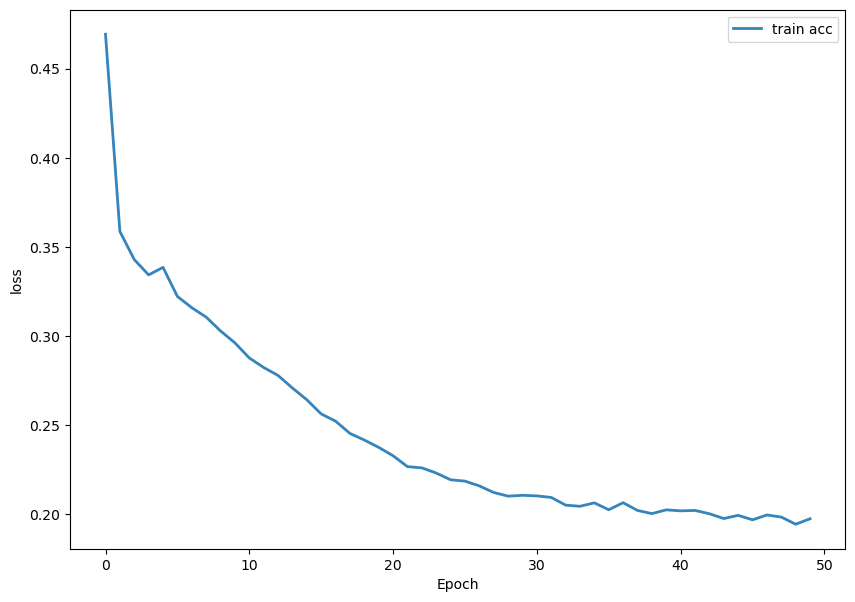

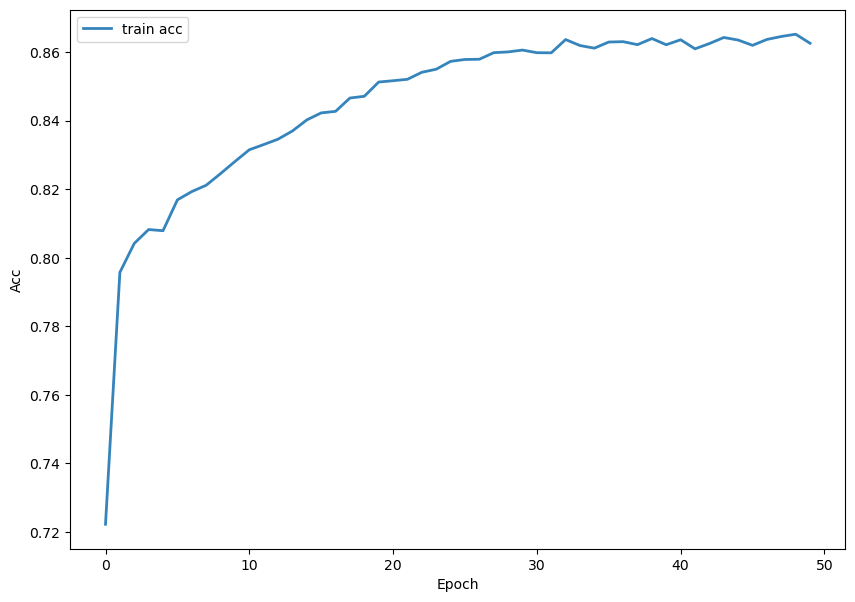

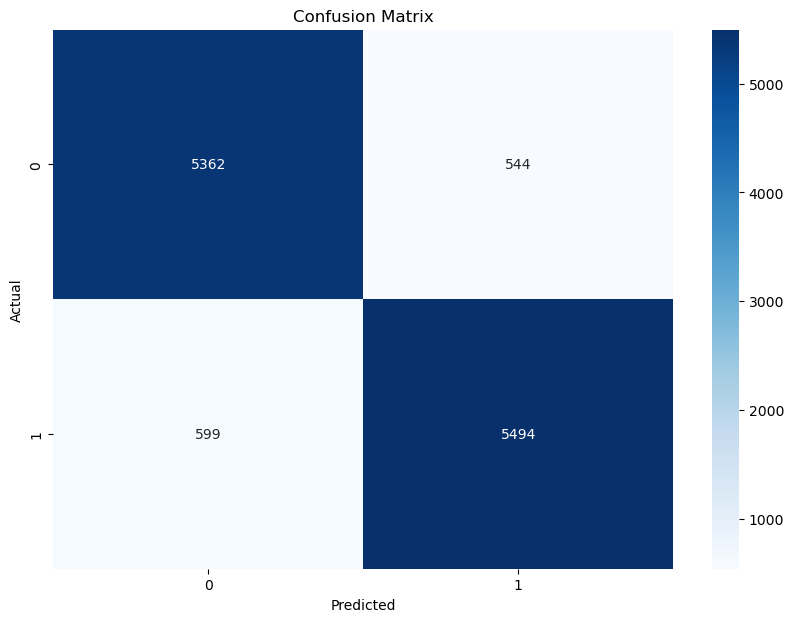

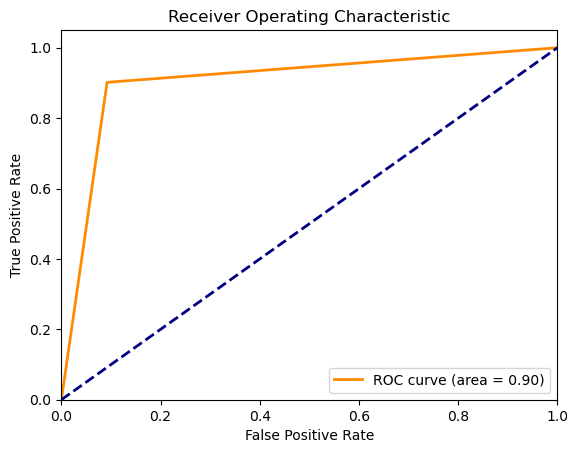

test_loss: 0.217      test_acc: 90.47%
end


In [36]:
# 设置随机种子，以确保结果的可重复性
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True  # 保证每次结果一样

start_time = time.time()
print("Loading data...")
vocab, train_data, dev_data, test_data = get_data()# 加载数据集
# 创建数据加载器
dataloaders = {
        'train': DataLoader(TextDataset(train_data), batch_size, shuffle=True),
        'dev': DataLoader(TextDataset(dev_data), batch_size, shuffle=True),
        'test': DataLoader(TextDataset(test_data), batch_size, shuffle=True)
}
end_time = time.time()
time_dif=end_time - start_time
print("Time usage:", time_dif)#数据处理用时
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')#设备选择
model = Model().to(device)
init_network(model)# 初始化模型参数
train(model, dataloaders)#进行模型训练及验证和评估
print('end')